# Problem Statement

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.


# Data definition
 

The data is provided in two tables, stores and train. The store table contains the metadata for every single store including the following:

 

<b>Store</b> - an Id that represents the store

<b>StoreType</b> - differentiates between 4 different store models: a, b, c, d

<b>Assortment</b> - describes an assortment level: a = basic, b = extra, c = extended

<b>CompetitionDistance</b> - describes thedistance in meters to the nearest competitor store

<b>CompetitionOpenSince[Month/Year]</b> - gives the approximate year and month of the time the nearest competitor was opened

<b>Promo2</b> - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

<b>Promo2Since[Year/Week]</b> - describes the year and calendar week when the store started participating in Promo2

<b>PromoInterval</b> - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store


<b>The train table contains the sales data for individual stores at a daily level along with the details about the day</b>

<b>Store</b> - a unique Id for each store

<b>DayOfWeek</b> - Describes the day of the week (1 - Monday till 7 - Sunday)

<b>Date</b> - Describes the date on the day

<b>Sales</b> - the turnover for any given day (this is what you are forecasting)

<b>Customers</b> - the number of customers on a given day

<b>Open</b> - an indicator for whether the store was open: 0 = closed, 1 = open

<b>StateHoliday</b> - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

<b>SchoolHoliday</b> - indicates if the (Store, Date) was affected by the closure of public schools

 

Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.


While attempting to forecast sales, it is advisable to keep the following question in mind.

 

- Is the sales data non-stationary? If so, how do you find it and correct it?

- Is the data cointegrated? Which variables are cointegrated and how do you find them?

- What is the impact of the number of customers on sales?

- What is the impact of promo and promo2 variables on sales? How do you measure it?

- Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE.

 
While you are solving the problem, the following steps can be used as a reference. Please note that you can take a different approach as well.


- Find outliers at the 99th percentile and remove them.

- Standardize the sales and number of customers variables before modelling.

- Determine if the data is stationary

- If stationary then apply Vector Autoregression Model.

- If non-stationary then specify the model in differences

- Make sales, promo2 and any other variables you think of as dependent variables.

- Check for cointegration using the Johansen test. 

- Predict sales for the next 6 weeks.

# Importing required libraries

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

# Importing Data

In [6]:
train = pd.read_csv("Dataset/train.csv")
store = pd.read_csv("Dataset/store.csv")

In [7]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# EDA

In [9]:
# checking shape of train data
train.shape

(1017209, 9)

In [10]:
# print info of train dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [11]:
# find percentage of null values in each columns
100*train.isnull().sum()/train.shape[0]

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

- <b>Train data does not have any null valies, so no imputation needed.</b>

In [13]:
# describing train datasets
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [14]:
# view store dataset
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [15]:
# print store dataframe shape
store.shape

(1115, 10)

In [16]:
# print info of store datasets
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [17]:
# finding percentage of null values in each columns in store datasets
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

- We have columns having null values, we need to impute those columns.
- The lack of promotional values indicates that there are no active promotions in the store, which can be represented by a value of zero.
- So Promo2SinceWeek, Promo2SinceYear, PromoInterval can be filled with 0.
- CompetitionDistance has very minimal null values, can be imputed by mean.

In [19]:
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna(0, inplace=True)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [20]:
# checking again null values in store dataframe
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

- <b>The variables CompetitionOpenSinceMonth and CompetitionOpenSinceYear currently hold null values, which will be addressed in a subsequent phase after further analysis.</b>

# Univariate Data Analysis on datasets

In [23]:
# A fucntion to create count plot
def count_plot(features,df):
    cols=4
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(16, rows*5))
    dataframe = df.copy()
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        dataframe[feature] = dataframe[feature].fillna('Missing')
        ax = sns.countplot(x=feature, data=dataframe,order = dataframe[feature].value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("for {}".format(feature))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}'.format(height/len(dataframe) * 100),
                    ha="center")

In [24]:
# below are the store data categorical fields
store_categorical_fields=['StoreType',
                          'Assortment',
                          'CompetitionOpenSinceMonth',
                          'CompetitionOpenSinceYear',
                          'Promo2',
                          'Promo2SinceWeek',
                          'Promo2SinceYear',
                          'PromoInterval'
                         ]

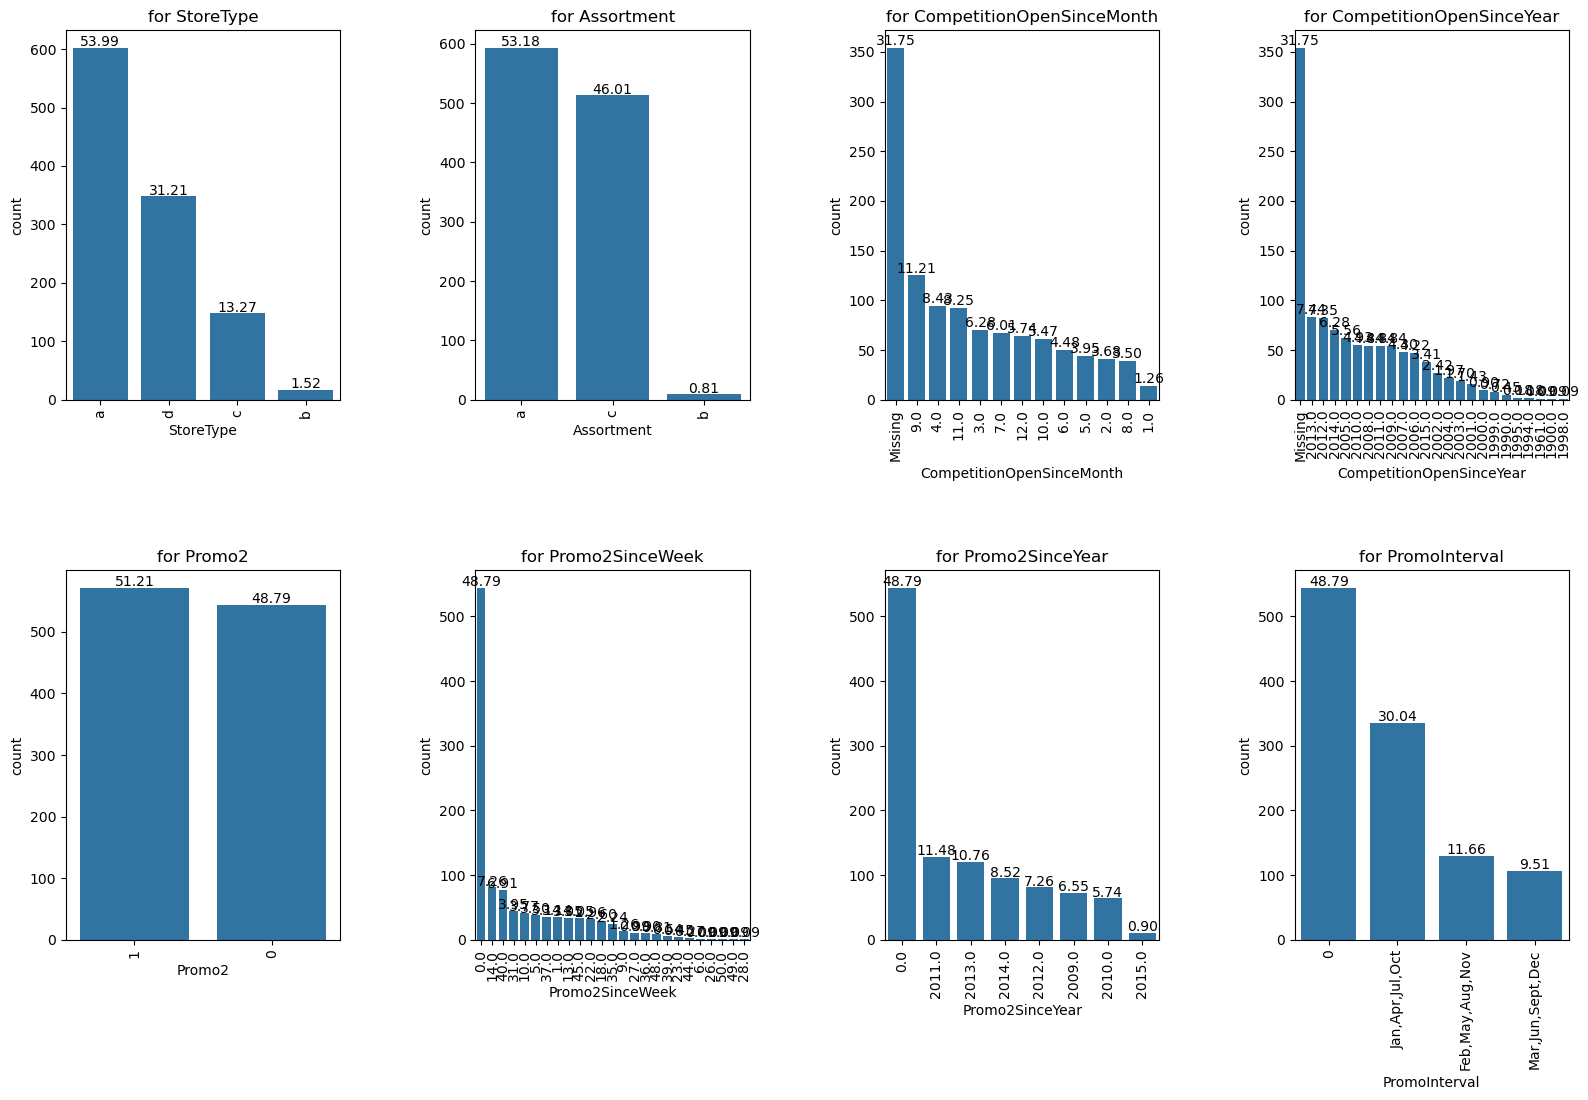

In [25]:
# plotting count plot for store data catogorical fileld
count_plot(store_categorical_fields,store)

- Observation on store data
    - A significant portion of the stores, nearly 54%, are classified as type A stores.
    - Most of the stores predominantly carry type A assortments,
    - Data for Competition is Null for 31% of the stores, meaning there is either no competition for those stores or the data is missing.
    - 48% of the stores do not have promotions
    - Promotions are primarily focused during the months of January, April, July, and October.

# Analysis for train data

In [28]:
# categoric variables for train data
train_categorical_columns=['DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

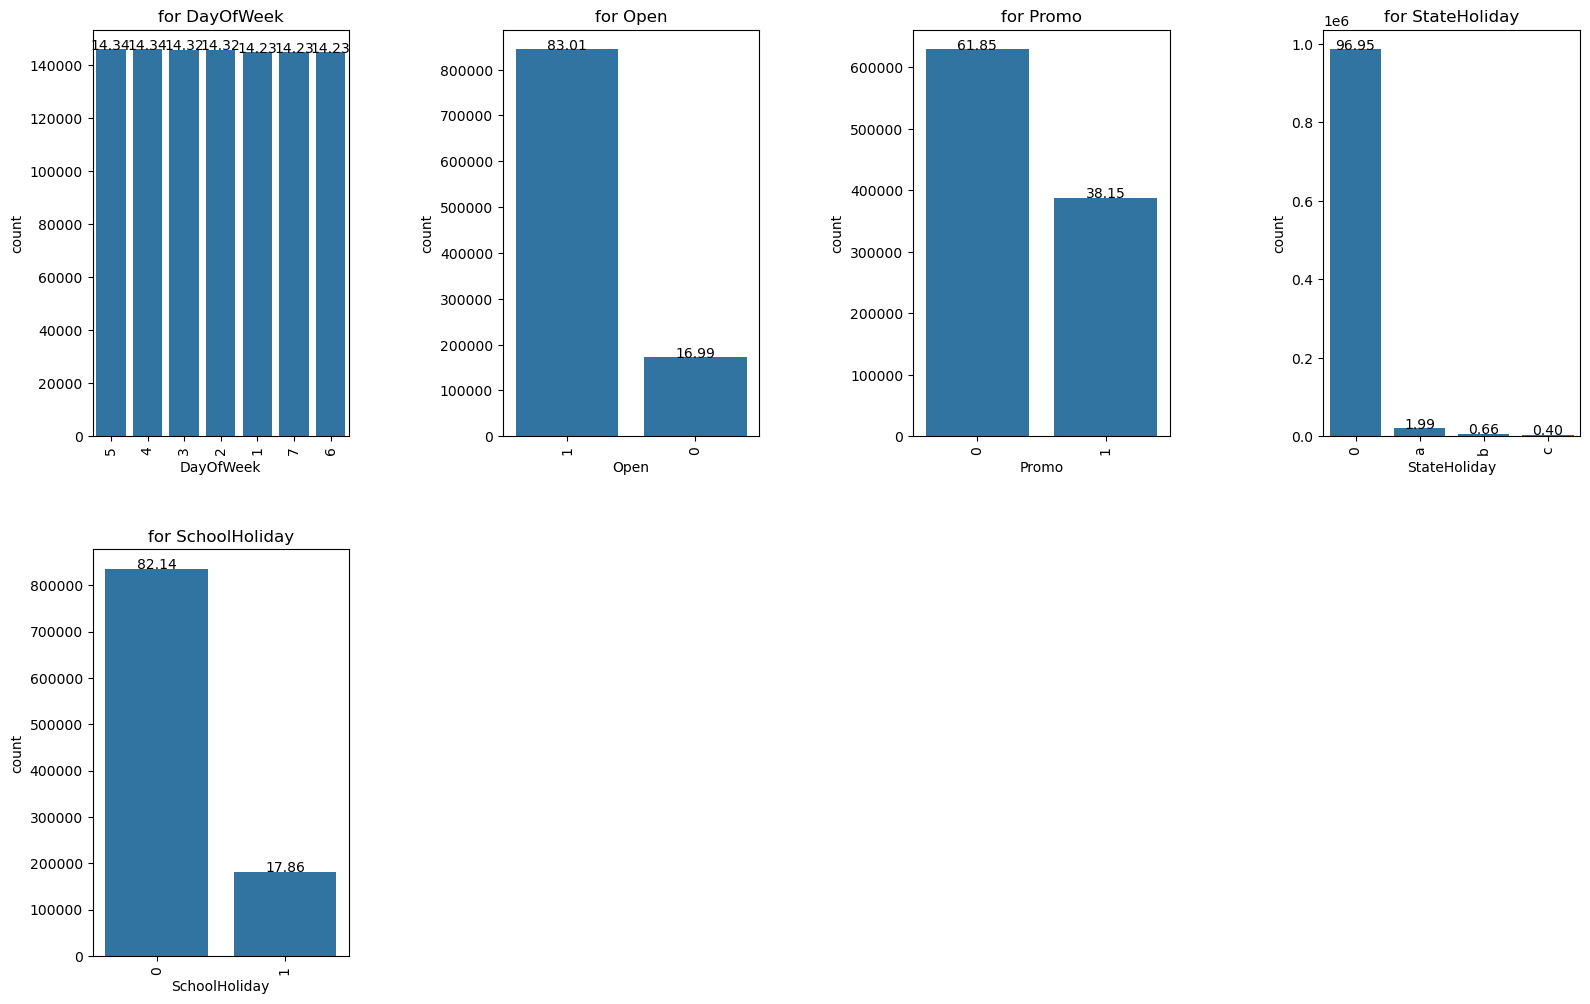

In [29]:
# plotting count plot for train data
count_plot(train_categorical_columns, train)

- Observation on train data
    - Each day of the week contributes equally.
    - Stores remain closed in only 17% of the data points.
    - Promotions are active in merely 38% of the records.

# Box plot and outlier analysis on datasets

## Box plot for store data

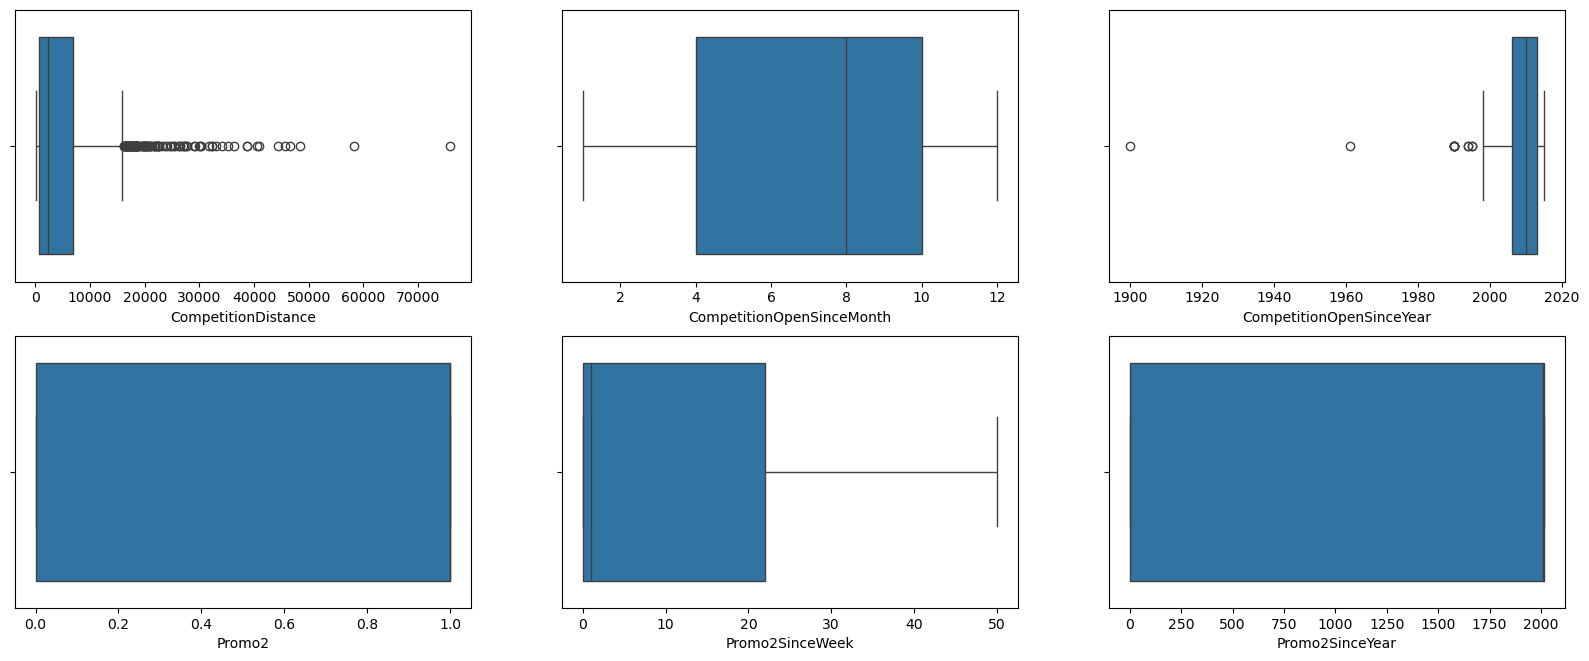

In [33]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'CompetitionDistance', data = store)
plt.subplot(3,3,2)
sns.boxplot(x = 'CompetitionOpenSinceMonth', data = store)
plt.subplot(3,3,3)
sns.boxplot(x = 'CompetitionOpenSinceYear',data = store)
plt.subplot(3,3,4)
sns.boxplot(x = 'Promo2', data = store)
plt.subplot(3,3,5)
sns.boxplot(x = 'Promo2SinceWeek', data = store)
plt.subplot(3,3,6)
sns.boxplot(x = 'Promo2SinceYear', data = store)
plt.show()

- From above box plot
    - It indicate the presence of outliers in the attributes of CompetitionDistance and CompetitionOpenSinceYear. A thorough analysis of these outliers is necessary.
    - Regarding CompetitionDistance, it is advisable to exclude values that exceed the 99th percentile. We will adjust any values that surpass the 99th percentile to align with the 99th percentile threshold.

In [35]:
# capping values of CompetitionDistance to 99th percentile
store.loc[store.CompetitionDistance>store.CompetitionDistance.quantile(.99),'CompetitionDistance']=store.CompetitionDistance.quantile(.99)

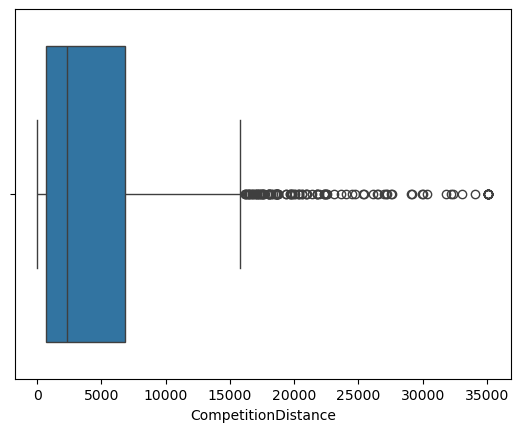

In [36]:
sns.boxplot(x = 'CompetitionDistance', data = store)
plt.show()

- The distance values seem to be in considerable range now.

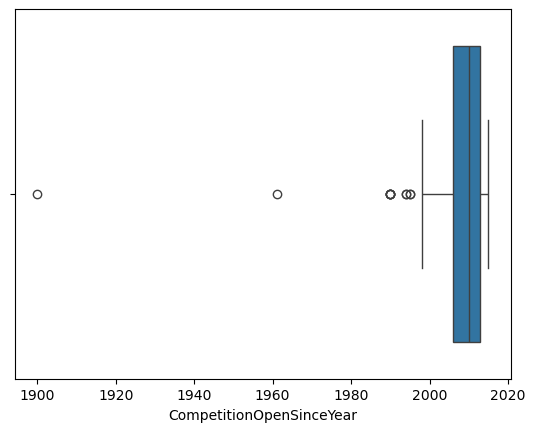

In [38]:
sns.boxplot(x = 'CompetitionOpenSinceYear', data = store)
plt.show()

In [39]:
store['CompetitionOpenSinceYear'].isnull().sum()

354

- CompetitionOpenSinceYear is null for 354 stores

In [41]:
# Checking the values of stores CompetitionDistance is null 
store.loc[store.CompetitionDistance.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store


- The CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear can be imputed them with zero

In [43]:
store.loc[store.CompetitionDistance.isnull(),'CompetitionOpenSinceMonth']=0
store.loc[store.CompetitionDistance.isnull(),'CompetitionOpenSinceYear']=0
store.loc[store.CompetitionDistance.isnull(),'CompetitionDistance']=0

In [44]:
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

- CompetitionOpenSinceMonth and CompetitionOpenSinceYear are null for 31% of stores, lets check those columns

In [46]:
store.loc[store.CompetitionOpenSinceMonth.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store
11,1070.0,NaN,NaN,12
12,310.0,NaN,NaN,13
15,3270.0,NaN,NaN,16
18,3240.0,NaN,NaN,19
21,1040.0,NaN,NaN,22
...,...,...,...,...
1095,1130.0,NaN,NaN,1096
1099,540.0,NaN,NaN,1100
1112,9260.0,NaN,NaN,1113
1113,870.0,NaN,NaN,1114


In [47]:
store.loc[store.CompetitionOpenSinceYear.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store
11,1070.0,NaN,NaN,12
12,310.0,NaN,NaN,13
15,3270.0,NaN,NaN,16
18,3240.0,NaN,NaN,19
21,1040.0,NaN,NaN,22
...,...,...,...,...
1095,1130.0,NaN,NaN,1096
1099,540.0,NaN,NaN,1100
1112,9260.0,NaN,NaN,1113
1113,870.0,NaN,NaN,1114


- No data is available for competition store openings, let's impute them with zero

In [49]:
store.CompetitionOpenSinceYear.fillna(0,inplace=True)
store.CompetitionOpenSinceMonth.fillna(0,inplace=True)

In [50]:
100*store.isnull().sum()/store.shape[0]

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

# Merging the datasets

In [52]:
train = train.merge(right=store, on='Store', how='inner')

In [53]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [54]:
train.shape

(1017209, 18)

In [55]:
# Checking percentage of null records
100*train.isnull().sum()/train.shape[0]

Store                        0.0
DayOfWeek                    0.0
Date                         0.0
Sales                        0.0
Customers                    0.0
Open                         0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

# Bivariate Analysis on Data

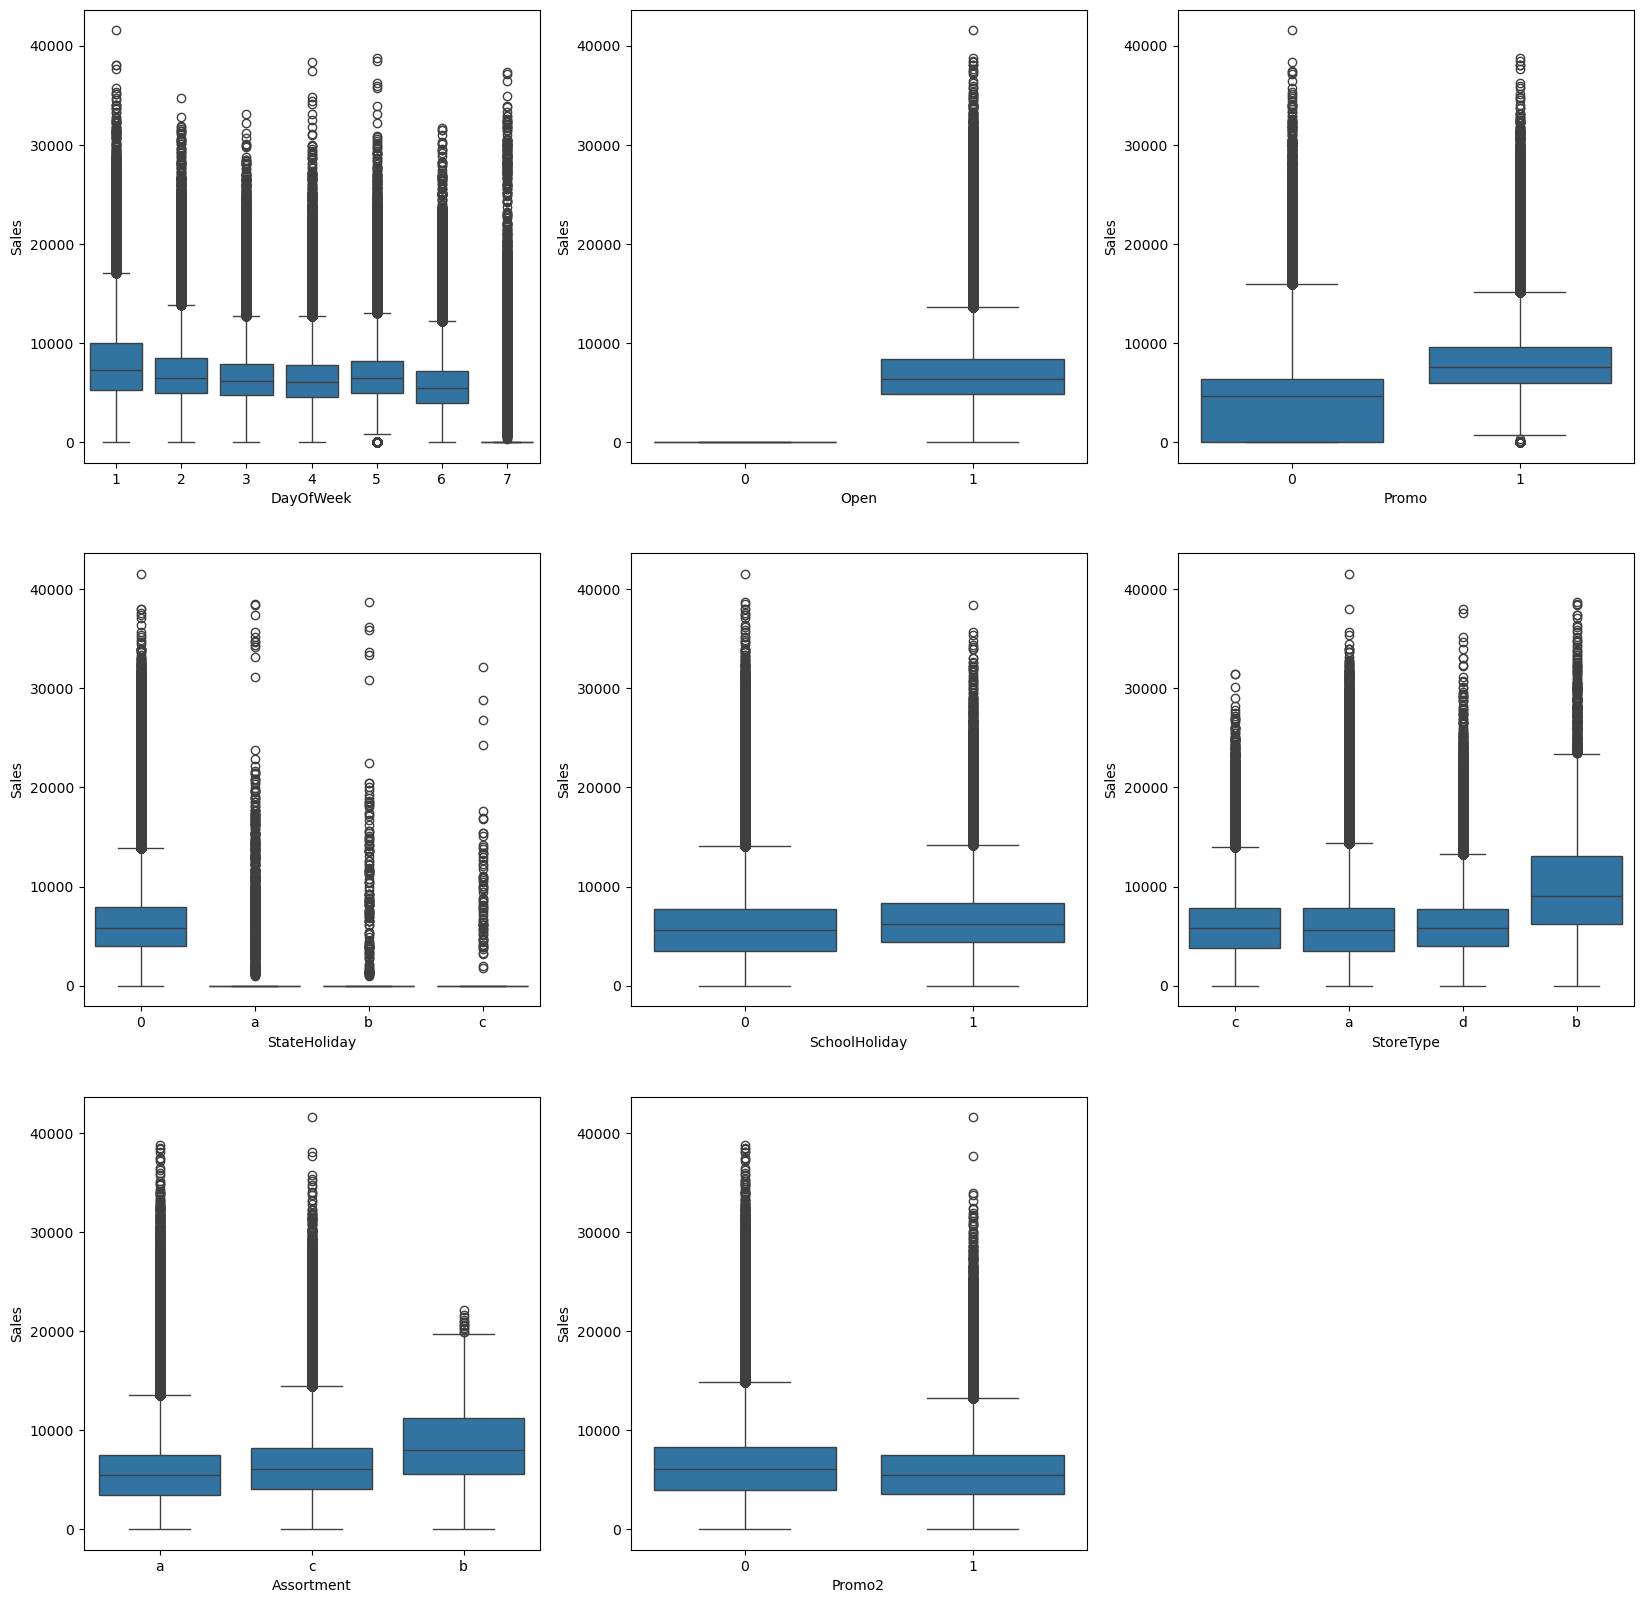

In [57]:
# creating Boxplots of attributes against Sales
plt.figure(figsize=(20, 20))
plt.subplot(3,3,1)
sns.boxplot(x = 'DayOfWeek', y = 'Sales', data = train)
plt.subplot(3,3,2)
sns.boxplot(x = 'Open', y = 'Sales', data = train)
plt.subplot(3,3,3)
sns.boxplot(x = 'Promo', y = 'Sales', data = train)
plt.subplot(3,3,4)
sns.boxplot(x = 'StateHoliday', y = 'Sales', data = train)
plt.subplot(3,3,5)
sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = train)
plt.subplot(3,3,6)
sns.boxplot(x = 'StoreType', y = 'Sales', data = train)
plt.subplot(3,3,7)
sns.boxplot(x = 'Assortment', y = 'Sales', data = train)
plt.subplot(3,3,8)
sns.boxplot(x = 'Promo2', y = 'Sales', data = train)
plt.show()


- Observation on merged Data
    - Sales are higher on 1st, 2nd and 5th weekdays. Sales are very low on 7th weekday.
    - Sales are higher when promotion is 1
    - On state holidays, a, b and c, sales are low
    - School holidays do not seem to impact sales
    - Store type B has higher % of sales than other store types
    - Assortment type B has higher sales
    - Promo2 does not seem to have much contribution to sales

## Scatter Plot Analysis

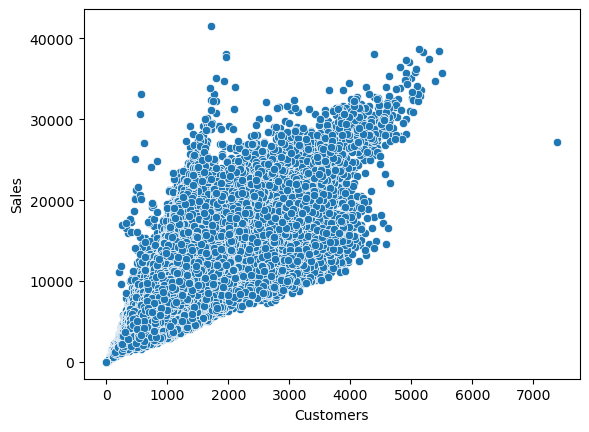

In [60]:
sns.scatterplot(x = 'Customers', y = 'Sales', data = train)
plt.show()

- Observation increase number of customers correlates an increase in sales

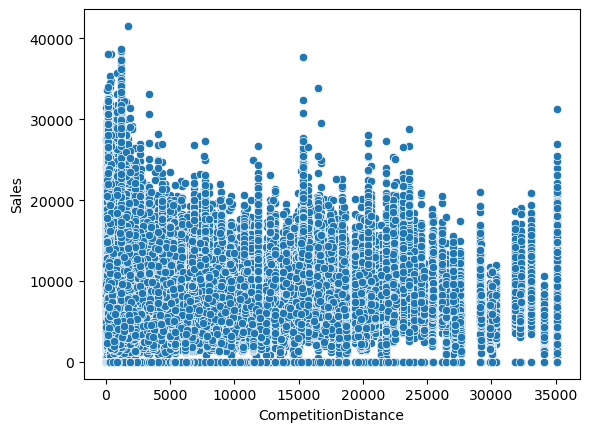

In [62]:
# Boxplots of Customers against Sales
sns.scatterplot(x = 'CompetitionDistance', y = 'Sales', data = train)
plt.show()

- from above plot competition does not seem to have any correlations against sales

## Multivariate Analysis

## Categorical variables

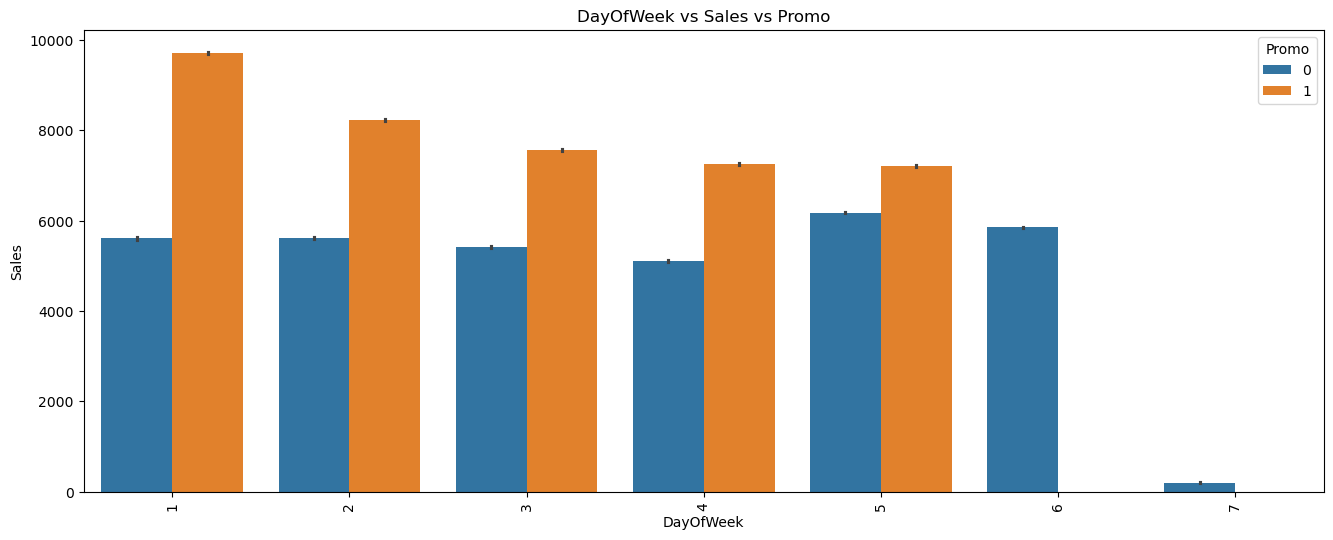

In [66]:
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek',y='Sales',hue='Promo',data=train)
plt.title("DayOfWeek vs Sales vs Promo")
plt.xticks(rotation = 90)
plt.show()

- From above plot it seems, promotion has a strong co-relation with sales of the stores.

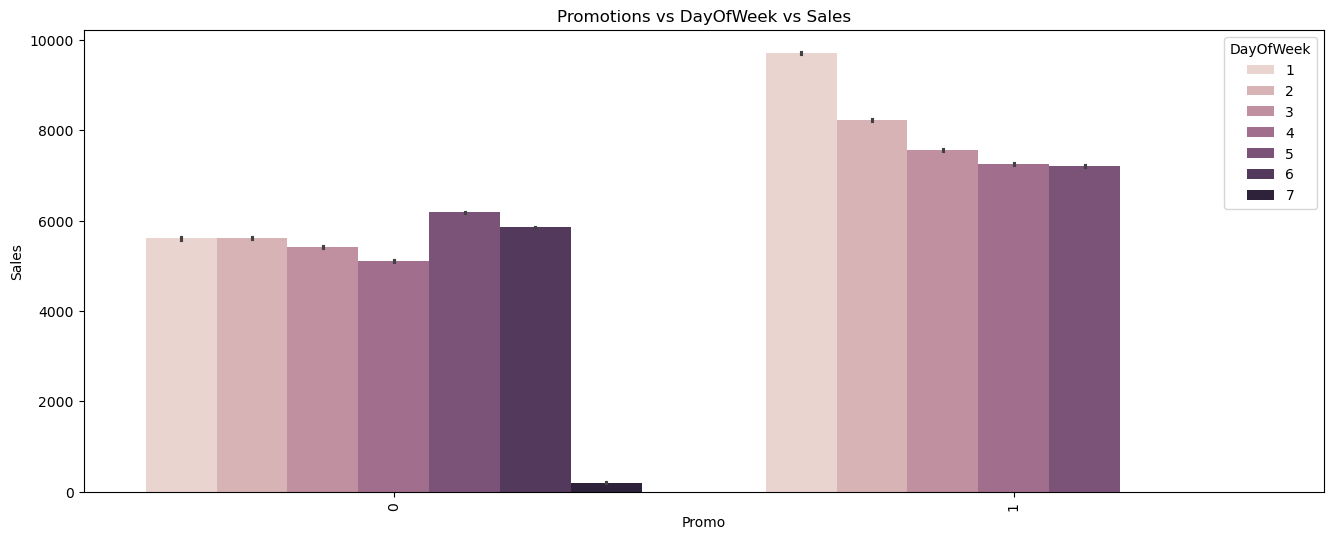

In [68]:
plt.figure(figsize=(16, 6))
sns.barplot(x='Promo',y='Sales',hue='DayOfWeek',data=train)
plt.title("Promotions vs DayOfWeek vs Sales")
plt.xticks(rotation = 90)
plt.show()

- From above plot, it seems days at the start of the week are higher Sales than sales of other days

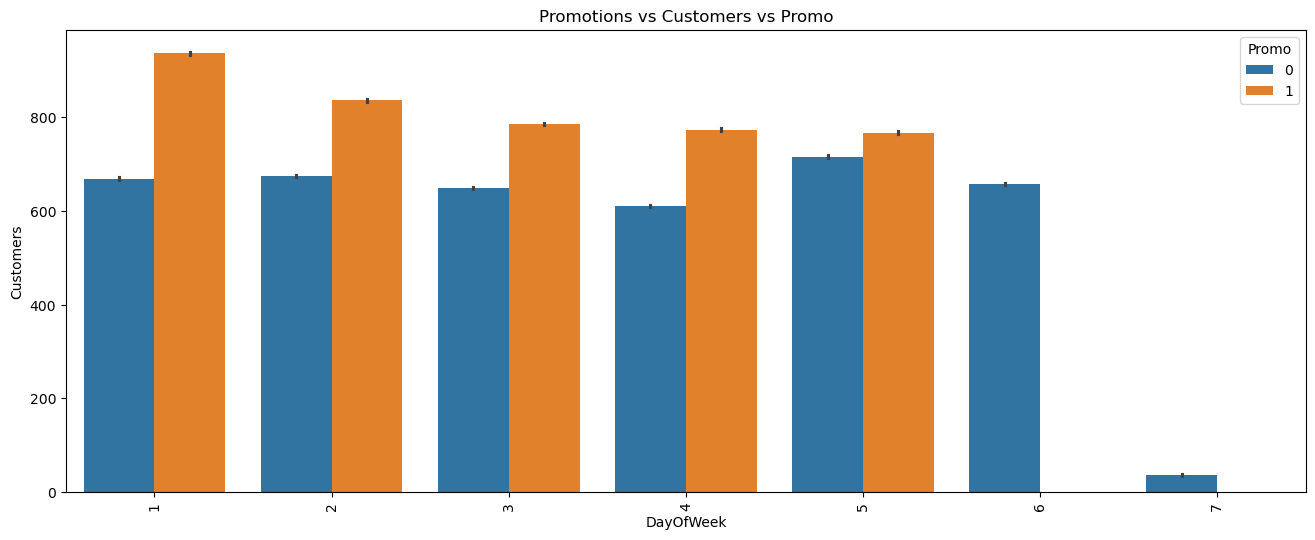

In [70]:
# Checking co-relation between Days vs Customers vs Promo 
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek',y='Customers',hue='Promo',data=train)
plt.title("Promotions vs Customers vs Promo")
plt.xticks(rotation = 90)
plt.show()

- From above plot, it observerd, customers are higher on weekdays and when promotios are active

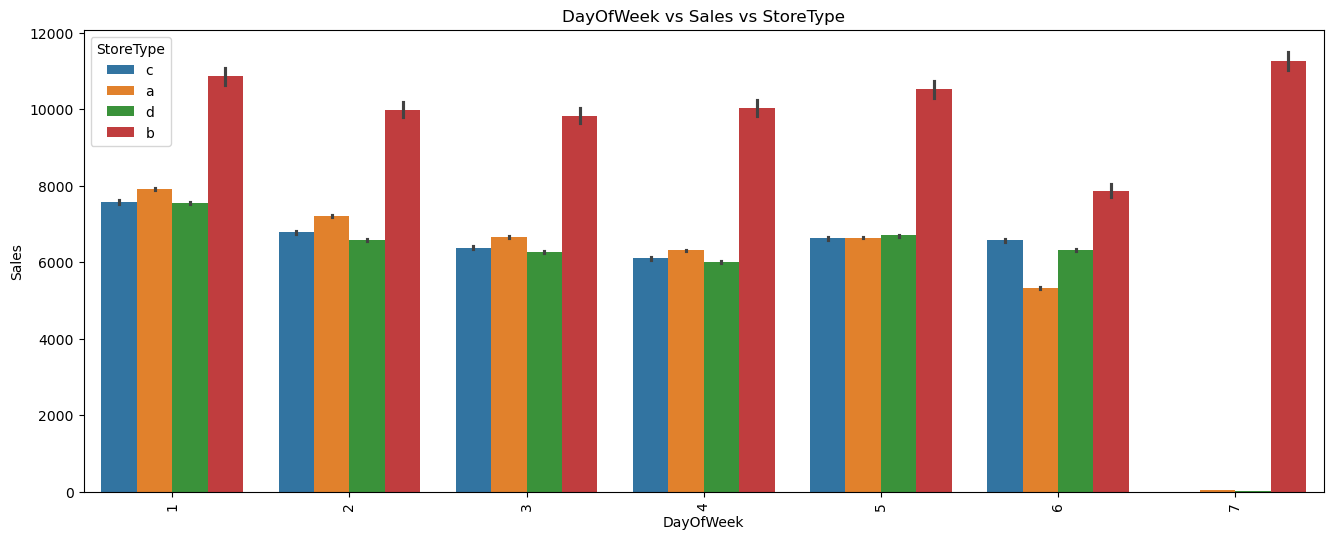

In [72]:
# Checking co-relation between Days vs Sales vs StoreType 

plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek',y='Sales',hue='StoreType',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

- Sales for store type b is the highest among all days including day 7 where sales for other store type is almost zero. On day 6, the difference in sales among store type is marginally lower than other days

## Numerical variables analysis

<Figure size 4000x4000 with 0 Axes>

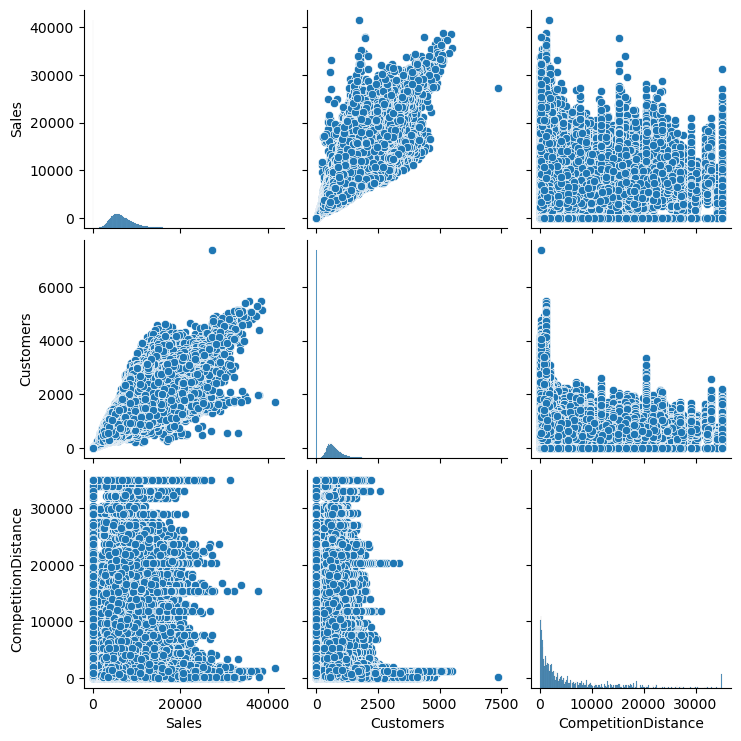

In [75]:
# Pairwise plot
plt.figure(figsize=(40, 40))
sns.pairplot(train[['Sales','Customers','CompetitionDistance']])
plt.show()

- From above plot, we can see that as customers increase, sales also increases.

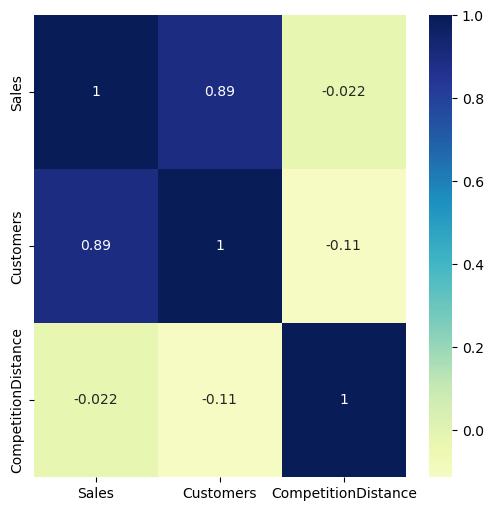

In [77]:
# Checking co-relation coefficients for numercial variables
# plotting heat map for corr
cor = train[['Sales','Customers','CompetitionDistance']].corr()
plt.figure(figsize = (6, 6))
sns.heatmap(cor, annot = True,center=0.4,cmap="YlGnBu")
plt.show()

- Sales and customer have a very strong correlated with a factor of 0.89. For other variables, it is not significant.

# Feature Engineering

- Creating dummy variables

In [81]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [82]:
# Creating dummy variable for day of the week 
dummies=pd.get_dummies(train['DayOfWeek'],prefix='DayOfWeek', dtype=int)
train=pd.concat([train,dummies],axis=1)

In [83]:
# Creating dummy variable for StoreType 
dummies=pd.get_dummies(train['StoreType'],prefix='StoreType', dtype=int)
train=pd.concat([train,dummies],axis=1)

In [84]:
# Creating dummy variable for Assortment 
dummies=pd.get_dummies(train['Assortment'],prefix='Assortment', dtype=int)
train=pd.concat([train,dummies],axis=1)

In [85]:
# Viewing data
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1,0,0,0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,0,0,1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,0,0,1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,1,0,0,0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,1,0,0,1,0,0,0,1,0,0


In [86]:
# Dropping DayOfWeek, StoreType and Assortment
train.drop(['DayOfWeek','StoreType','Assortment'],axis=1,inplace=True)
train.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,2015-07-31,5263,555,1,1,0,1,1270.0,9.0,...,1,0,0,0,0,1,0,1,0,0
1,2,2015-07-31,6064,625,1,1,0,1,570.0,11.0,...,1,0,0,1,0,0,0,1,0,0
2,3,2015-07-31,8314,821,1,1,0,1,14130.0,12.0,...,1,0,0,1,0,0,0,1,0,0
3,4,2015-07-31,13995,1498,1,1,0,1,620.0,9.0,...,1,0,0,0,0,1,0,0,0,1
4,5,2015-07-31,4822,559,1,1,0,1,29910.0,4.0,...,1,0,0,1,0,0,0,1,0,0


- For competition data, we can merge their date information into a single column

In [88]:
train['CompetitionOpenSince'] = train.CompetitionOpenSinceYear.astype(int).astype(str) + '-' + train.CompetitionOpenSinceMonth.astype(int).astype(str) + '-01'
train.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSince
0,1,2015-07-31,5263,555,1,1,0,1,1270.0,9.0,...,0,0,0,0,1,0,1,0,0,2008-9-01
1,2,2015-07-31,6064,625,1,1,0,1,570.0,11.0,...,0,0,1,0,0,0,1,0,0,2007-11-01
2,3,2015-07-31,8314,821,1,1,0,1,14130.0,12.0,...,0,0,1,0,0,0,1,0,0,2006-12-01
3,4,2015-07-31,13995,1498,1,1,0,1,620.0,9.0,...,0,0,0,0,1,0,0,0,1,2009-9-01
4,5,2015-07-31,4822,559,1,1,0,1,29910.0,4.0,...,0,0,1,0,0,0,1,0,0,2015-4-01


In [89]:
# Dropping CompetitionOpenSinceMonth, CompetitionOpenSinceYear fields
train.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)

In [90]:
# finding how many have CompetitionOpenSince as 0-0-01
train[train.CompetitionOpenSince=='0-0-01'].count()

Store                   323348
Date                    323348
Sales                   323348
Customers               323348
Open                    323348
Promo                   323348
StateHoliday            323348
SchoolHoliday           323348
CompetitionDistance     323348
Promo2                  323348
Promo2SinceWeek         323348
Promo2SinceYear         323348
PromoInterval           323348
DayOfWeek_1             323348
DayOfWeek_2             323348
DayOfWeek_3             323348
DayOfWeek_4             323348
DayOfWeek_5             323348
DayOfWeek_6             323348
DayOfWeek_7             323348
StoreType_a             323348
StoreType_b             323348
StoreType_c             323348
StoreType_d             323348
Assortment_a            323348
Assortment_b            323348
Assortment_c            323348
CompetitionOpenSince    323348
dtype: int64

- We many stores where competion opening dates were not available, the dates for CompetitionOpenSince for those stores needs to be impute with null

In [92]:
train.loc[train.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']

11         0-0-01
12         0-0-01
15         0-0-01
18         0-0-01
21         0-0-01
            ...  
1017189    0-0-01
1017193    0-0-01
1017206    0-0-01
1017207    0-0-01
1017208    0-0-01
Name: CompetitionOpenSince, Length: 323348, dtype: object

In [93]:
#Imputing them with null
train.loc[train.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']=np.nan

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Store                 1017209 non-null  int64  
 1   Date                  1017209 non-null  object 
 2   Sales                 1017209 non-null  int64  
 3   Customers             1017209 non-null  int64  
 4   Open                  1017209 non-null  int64  
 5   Promo                 1017209 non-null  int64  
 6   StateHoliday          1017209 non-null  object 
 7   SchoolHoliday         1017209 non-null  int64  
 8   CompetitionDistance   1017209 non-null  float64
 9   Promo2                1017209 non-null  int64  
 10  Promo2SinceWeek       1017209 non-null  float64
 11  Promo2SinceYear       1017209 non-null  float64
 12  PromoInterval         1017209 non-null  object 
 13  DayOfWeek_1           1017209 non-null  int64  
 14  DayOfWeek_2           1017209 non-

- Date and CompetitionOpenSince are date objects, we need convert them into datetime objects

In [96]:
# Converting date field to datetime object
train['Date']=pd.to_datetime(train['Date'],errors='coerce')

In [97]:
# Converting CompetitionOpenSince field to datetime object
train['CompetitionOpenSince']=pd.to_datetime(train['CompetitionOpenSince'],errors='coerce')

In [98]:
# Checking data types again
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Store                 1017209 non-null  int64         
 1   Date                  1017209 non-null  datetime64[ns]
 2   Sales                 1017209 non-null  int64         
 3   Customers             1017209 non-null  int64         
 4   Open                  1017209 non-null  int64         
 5   Promo                 1017209 non-null  int64         
 6   StateHoliday          1017209 non-null  object        
 7   SchoolHoliday         1017209 non-null  int64         
 8   CompetitionDistance   1017209 non-null  float64       
 9   Promo2                1017209 non-null  int64         
 10  Promo2SinceWeek       1017209 non-null  float64       
 11  Promo2SinceYear       1017209 non-null  float64       
 12  PromoInterval         1017209 non-null  ob

 - There will be store transaction dates where sales were made before competition started and sales after competition. Let's create a new flag for their identification

In [100]:
def calculate_compitition(row):
    if row.CompetitionOpenSince > row.Date:
        return 1
    else:
        return 0
train['Before_Competition']=train[['CompetitionOpenSince','Date']].apply(calculate_compitition,axis=1)

In [101]:
train.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,...,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSince,Before_Competition
0,1,2015-07-31,5263,555,1,1,0,1,1270.0,0,...,0,0,0,1,0,1,0,0,2008-09-01,0
1,2,2015-07-31,6064,625,1,1,0,1,570.0,1,...,0,1,0,0,0,1,0,0,2007-11-01,0
2,3,2015-07-31,8314,821,1,1,0,1,14130.0,1,...,0,1,0,0,0,1,0,0,2006-12-01,0
3,4,2015-07-31,13995,1498,1,1,0,1,620.0,0,...,0,0,0,1,0,0,0,1,2009-09-01,0
4,5,2015-07-31,4822,559,1,1,0,1,29910.0,0,...,0,1,0,0,0,1,0,0,2015-04-01,0


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 29 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Store                 1017209 non-null  int64         
 1   Date                  1017209 non-null  datetime64[ns]
 2   Sales                 1017209 non-null  int64         
 3   Customers             1017209 non-null  int64         
 4   Open                  1017209 non-null  int64         
 5   Promo                 1017209 non-null  int64         
 6   StateHoliday          1017209 non-null  object        
 7   SchoolHoliday         1017209 non-null  int64         
 8   CompetitionDistance   1017209 non-null  float64       
 9   Promo2                1017209 non-null  int64         
 10  Promo2SinceWeek       1017209 non-null  float64       
 11  Promo2SinceYear       1017209 non-null  float64       
 12  PromoInterval         1017209 non-null  ob

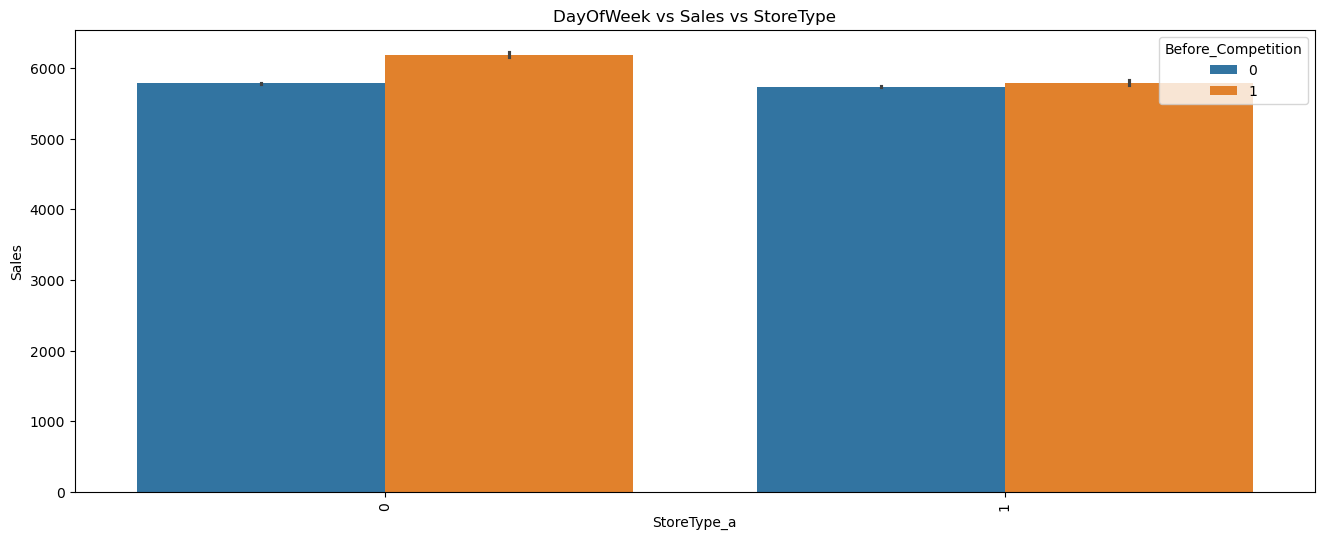

In [103]:
# Checking co-relation between StoreType_a vs Sales vs Before_Competition

plt.figure(figsize=(16, 6))
sns.barplot(x='StoreType_a',y='Sales', hue='Before_Competition',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

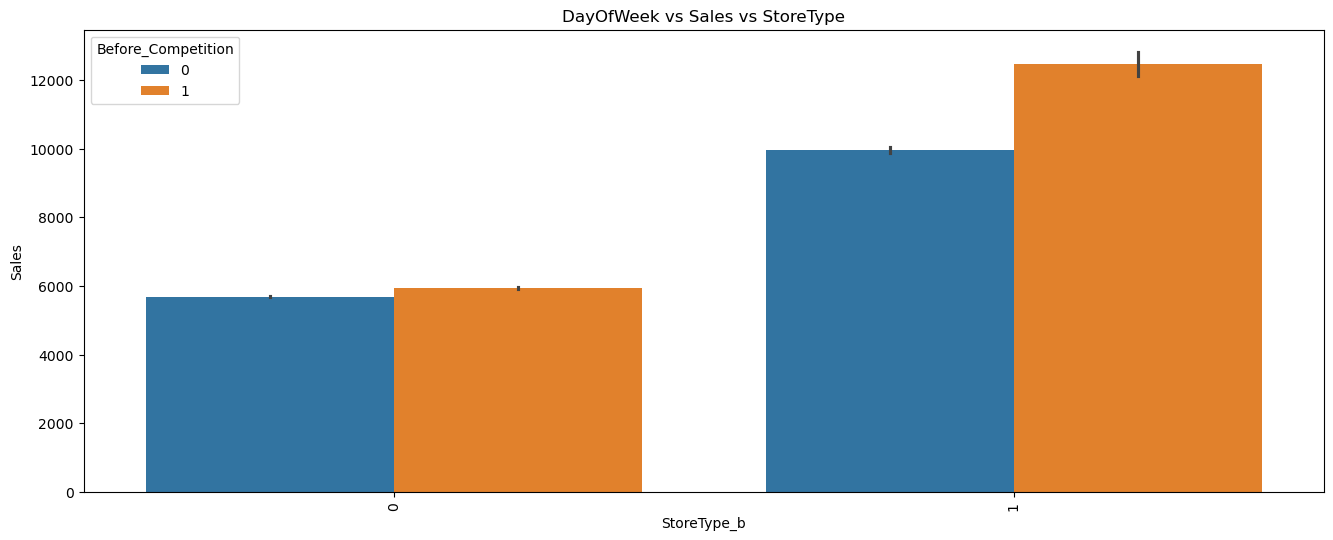

In [104]:
# Checking co-relation between StoreType_b vs Sales vs Before_Competition

plt.figure(figsize=(16, 6))
sns.barplot(x='StoreType_b',y='Sales', hue='Before_Competition',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

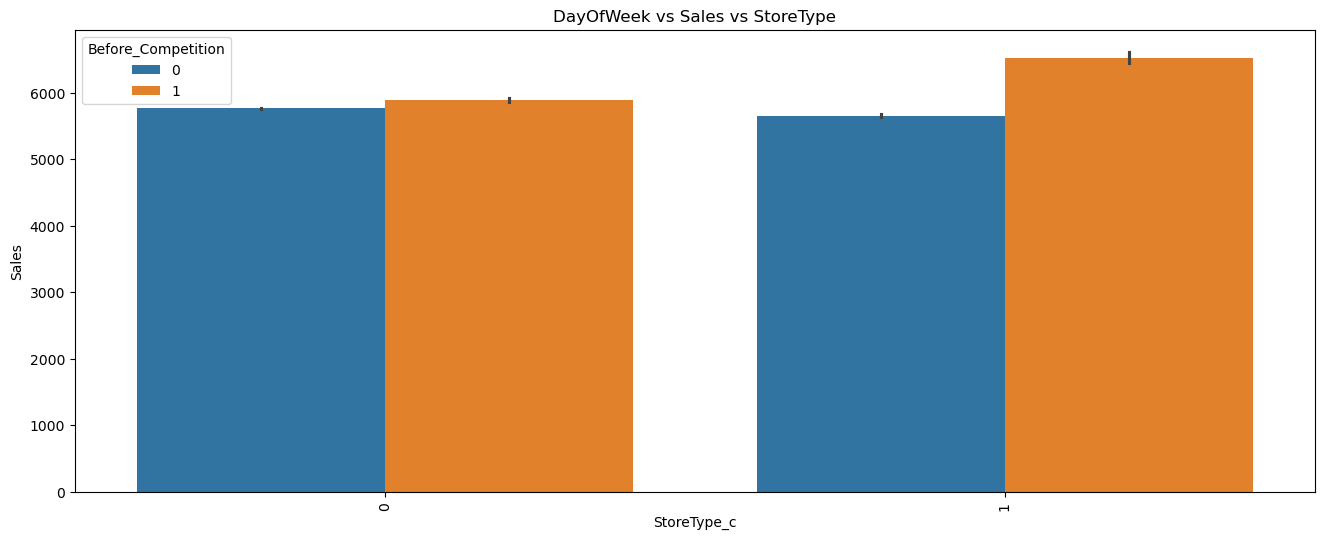

In [105]:
# Checking co-relation between StoreType_c vs Sales vs Before_Competition
plt.figure(figsize=(16, 6))
sns.barplot(x='StoreType_c',y='Sales', hue='Before_Competition',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

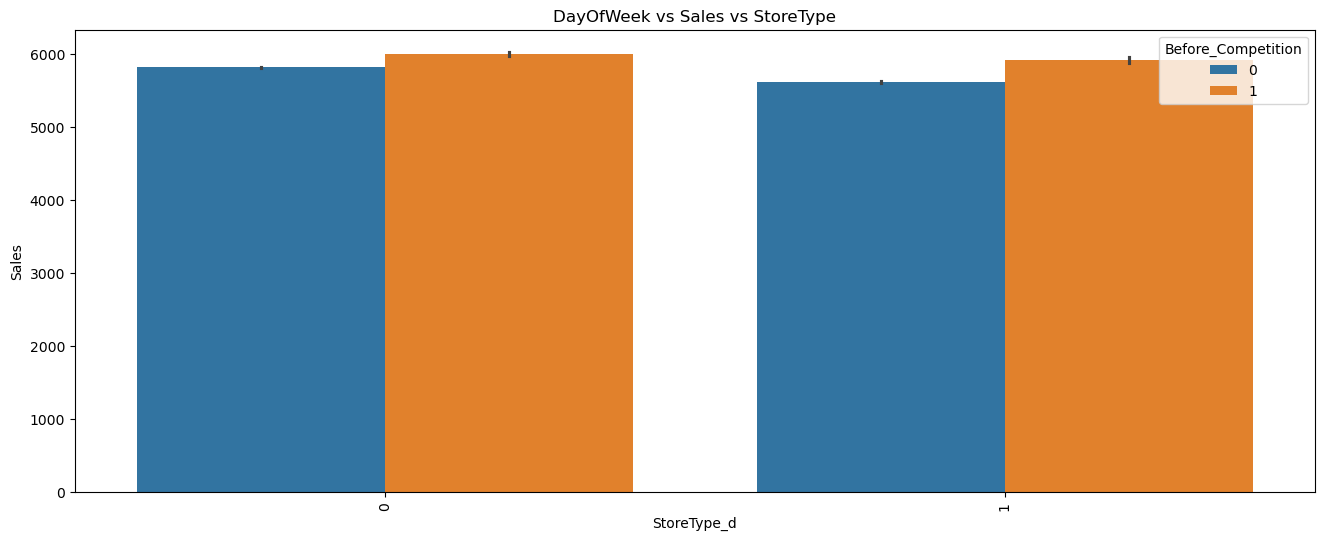

In [106]:
# Checking co-relation between StoreType_d vs Sales vs Before_Competition

plt.figure(figsize=(16, 6))
sns.barplot(x='StoreType_d',y='Sales', hue='Before_Competition',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

- Sales of stores before and after competition do not have much difference, we can drop this field

In [108]:
train.drop(['Before_Competition'],inplace=True,axis=1)

- We can also drop CompetitionOpenSince, since it is a field for derived Before_Competition

In [110]:
train.drop(['CompetitionOpenSince'],inplace=True,axis=1)

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   Date                 1017209 non-null  datetime64[ns]
 2   Sales                1017209 non-null  int64         
 3   Customers            1017209 non-null  int64         
 4   Open                 1017209 non-null  int64         
 5   Promo                1017209 non-null  int64         
 6   StateHoliday         1017209 non-null  object        
 7   SchoolHoliday        1017209 non-null  int64         
 8   CompetitionDistance  1017209 non-null  float64       
 9   Promo2               1017209 non-null  int64         
 10  Promo2SinceWeek      1017209 non-null  float64       
 11  Promo2SinceYear      1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

- We had seen earlier that Promo2 variables does not seem to have much impact on Sales, we can drop them

In [113]:
train.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear','Promo2SinceYear'],inplace=True,axis=1)

In [114]:
train.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,2015-07-31,5263,555,1,1,0,1,1270.0,0,...,1,0,0,0,0,1,0,1,0,0
1,2,2015-07-31,6064,625,1,1,0,1,570.0,"Jan,Apr,Jul,Oct",...,1,0,0,1,0,0,0,1,0,0
2,3,2015-07-31,8314,821,1,1,0,1,14130.0,"Jan,Apr,Jul,Oct",...,1,0,0,1,0,0,0,1,0,0
3,4,2015-07-31,13995,1498,1,1,0,1,620.0,0,...,1,0,0,0,0,1,0,0,0,1
4,5,2015-07-31,4822,559,1,1,0,1,29910.0,0,...,1,0,0,1,0,0,0,1,0,0


# Time Series Analysis

- Our previous analysis indicates that an increase in the number of customers directly correlates with an increase in sales, suggesting that customer counts serve as an endogenous variable in our predictive models.

In [117]:
# Setting date as index
train_df=train.set_index('Date')
train_df.head()

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,PromoInterval,DayOfWeek_1,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5263,555,1,1,0,1,1270.0,0,0,...,1,0,0,0,0,1,0,1,0,0
2015-07-31,2,6064,625,1,1,0,1,570.0,"Jan,Apr,Jul,Oct",0,...,1,0,0,1,0,0,0,1,0,0
2015-07-31,3,8314,821,1,1,0,1,14130.0,"Jan,Apr,Jul,Oct",0,...,1,0,0,1,0,0,0,1,0,0
2015-07-31,4,13995,1498,1,1,0,1,620.0,0,0,...,1,0,0,0,0,1,0,0,0,1
2015-07-31,5,4822,559,1,1,0,1,29910.0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [118]:
# Grouping the data at a date level for analysis

train_df_all=train_df.groupby('Date').agg({'Sales': 'mean',
                                           'Customers':'mean', 
                                           'Promo': 'sum',
                                           'SchoolHoliday':'sum',
                                           'DayOfWeek_1':'mean',
                                           'DayOfWeek_2':'mean',
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean'})

In [119]:
train_df_all.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,
2013-01-01,87.284560,17.496409,0,1114,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,6233.030493,748.049327,0,1115,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5693.112108,682.547085,0,1040,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,5954.218834,701.468161,0,1040,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,5337.751570,616.566816,0,112,0.0,0.0,0.0,0.0,0.0,1.0,0.0


- Creating a function for time series plots

In [121]:
def timeseries_plot(series,c):
    fig = plt.figure(figsize=(20, 3))
    series.plot()
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title('For {}'.format(c))
    plt.show()

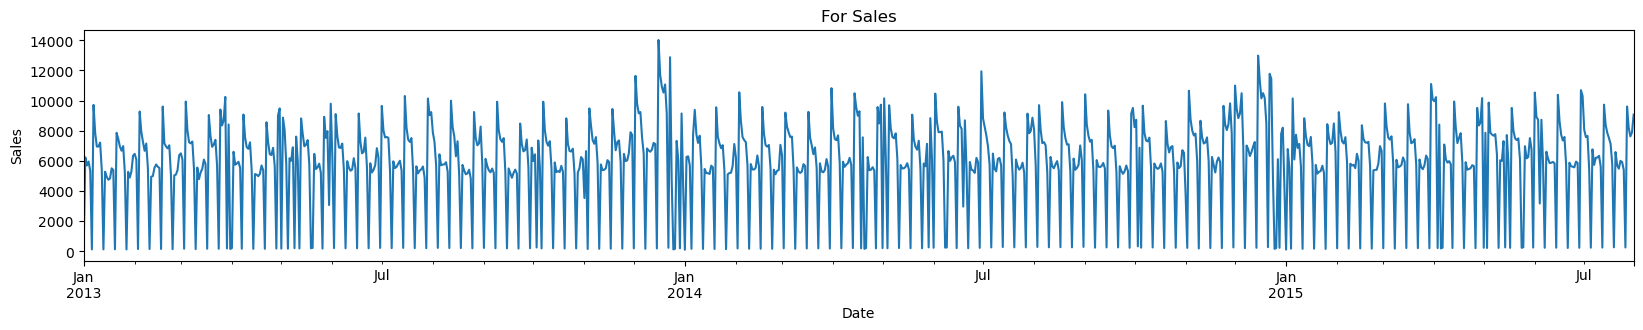

In [122]:
# Plotting time series chart for Sales
timeseries_plot(train_df_all['Sales'],'Sales')

## Creating function for seasonal decomposition

In [124]:
from pylab import rcParams
import statsmodels.api as sm
def plot_seasonal_decomposition(series,c,model):
    rcParams['figure.figsize'] = 18, 14
    decomposition = sm.tsa.seasonal_decompose(series, model=model) # additive seasonal index
    fig = decomposition.plot()
    plt.show()
    print('Mean Residual for {}={}'.format(c,decomposition.resid.mean()))

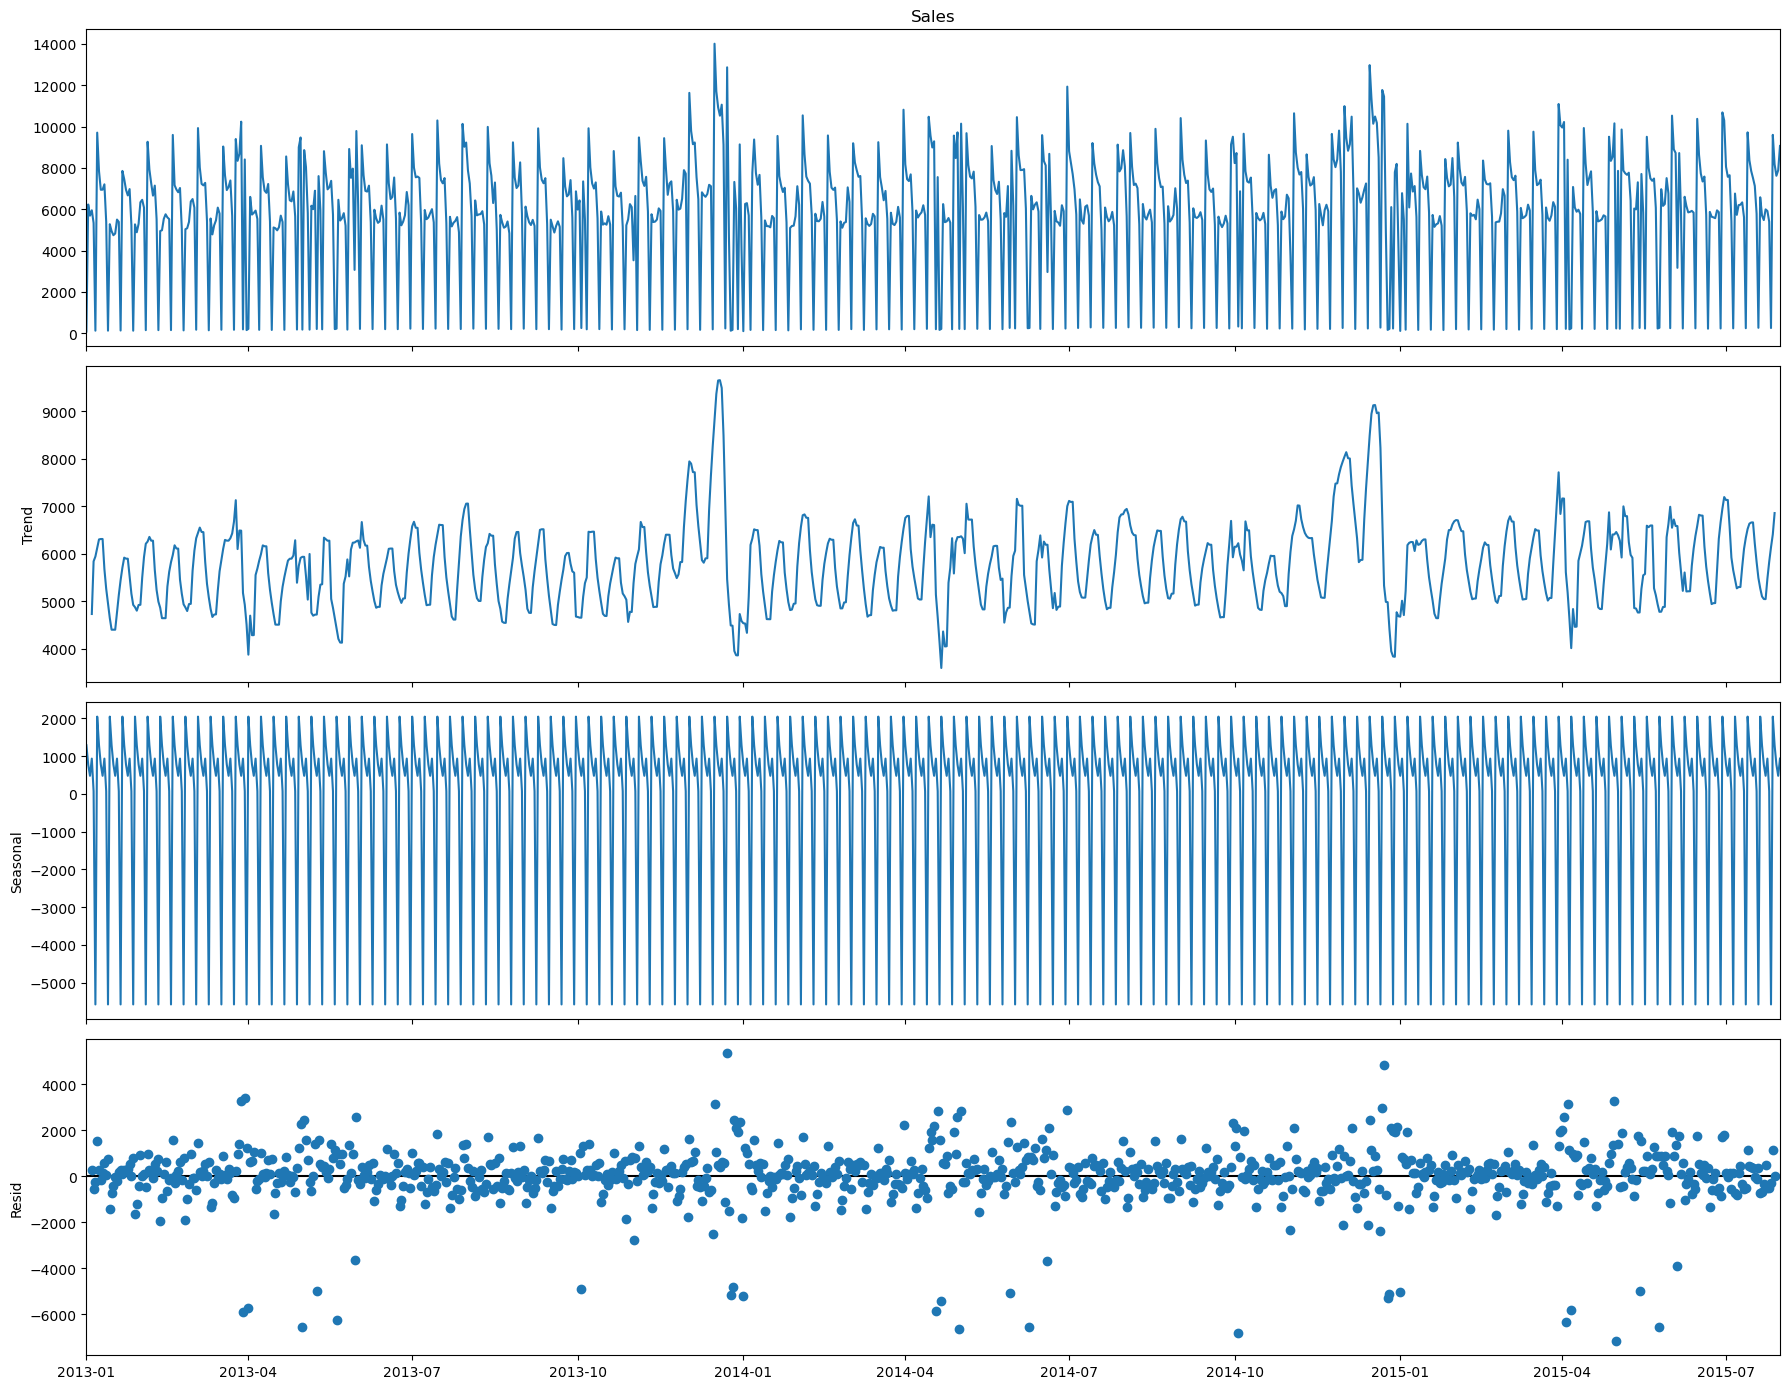

Mean Residual for Sales=0.6202792140320115


In [125]:
plot_seasonal_decomposition(train_df_all['Sales'],'Sales','additive')

### Casualty testing

- We have seen that Sales and Customers have a high co-relation. Let's check their casuality

In [128]:
from statsmodels.tsa.stattools import grangercausalitytests
causality_sales=grangercausalitytests(train_df_all[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=207.3179, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=207.9810, p=0.0000  , df=1
likelihood ratio test: chi2=187.9060, p=0.0000  , df=1
parameter F test:         F=207.3179, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=117.7859, p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=236.8316, p=0.0000  , df=2
likelihood ratio test: chi2=211.2191, p=0.0000  , df=2
parameter F test:         F=117.7859, p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=84.6075 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=255.7290, p=0.0000  , df=3
likelihood ratio test: chi2=226.1668, p=0.0000  , df=3
parameter F test:         F=84.6075 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=70.9777 , p=0.0000  

## Stationary test

- Creating a function for testing stationary using ADF statistic

In [131]:
from statsmodels.tsa.stattools import adfuller

def stationary_test(df):
    for c in df.columns:
        print('For ',c)
        print('*'*100)
        r=adfuller(df[c],autolag='AIC')
        print('ADF Statistic=',r[0])
        print('P value=',r[1])
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        if p_value <= 0.05:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")  

In [132]:
stationary_test(train_df_all[['Sales','Customers']])

For  Sales
****************************************************************************************************
ADF Statistic= -5.650822837207895
P value= 9.870006549262069e-07
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
For  Customers
****************************************************************************************************
ADF Statistic= -5.933710149589021
P value= 2.3477735379188178e-07
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


- The p-values for both the variables is less than 0.05. We can reject the null hypothesis. The series is stationary
- In the dataset, we do not have any other variable which is linearly related to Sales. They do not seem to be time series inputs for our analysis.

- We had earlier determined that since increase in customers relate to increased sales and since no other variable is a time series, we will consider them to be exogenous.

### Autocorelation
- Creating functions for ACF and PACF plots

In [136]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def plot_acf_pacf(series,c):
    rcParams['figure.figsize'] = 20, 3
    plot_acf(series, lags = 75)
    plt.title('ACF for {}'.format(c)) 
    plot_pacf(series, lags = 75)
    plt.title('PACF for {}'.format(c)) 
    plt.show()

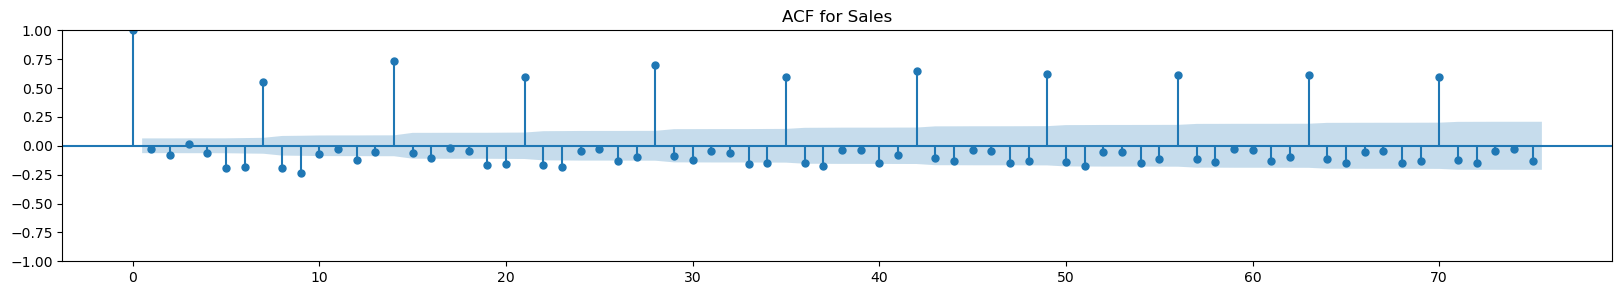

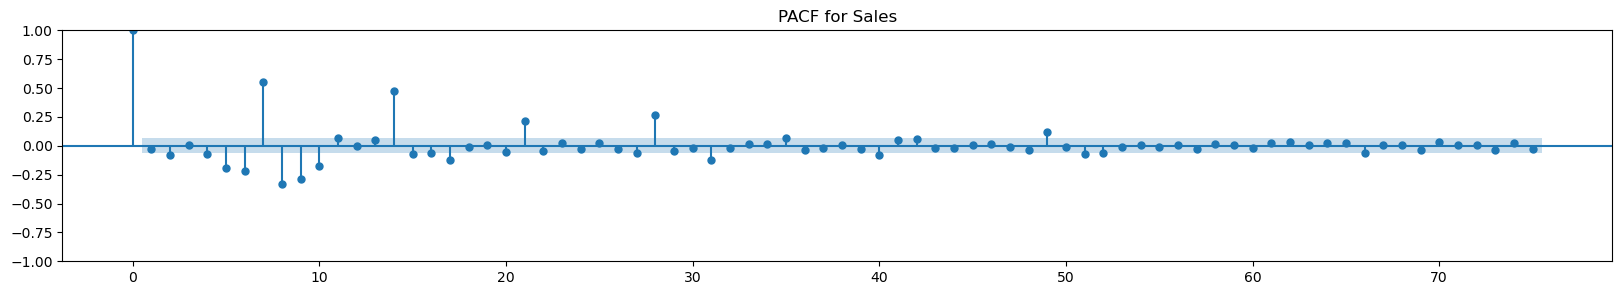

In [137]:
# Plotting ACF and PACF for sales
plot_acf_pacf(train_df_all['Sales'],'Sales')

- For ACF, we set q=0 as co-realation never comes dowm. For PACF, we set q=7, since it is the highest lag since inception.

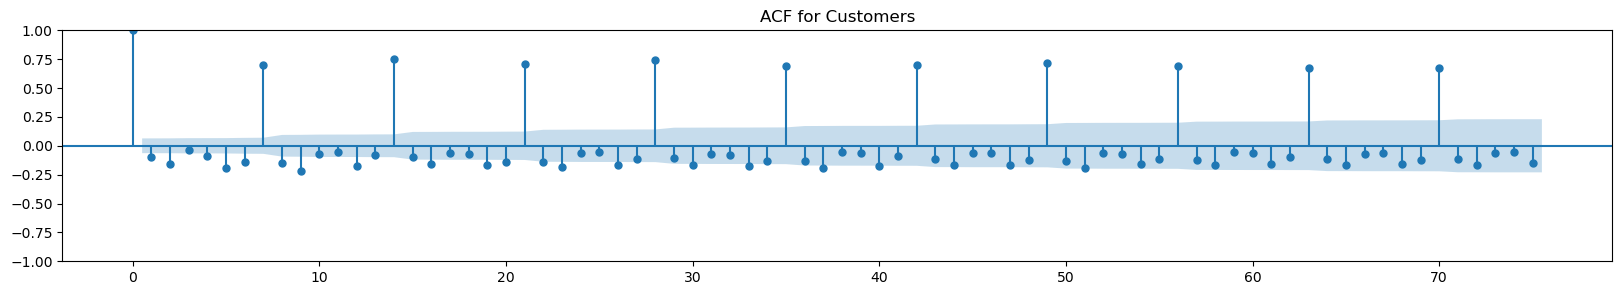

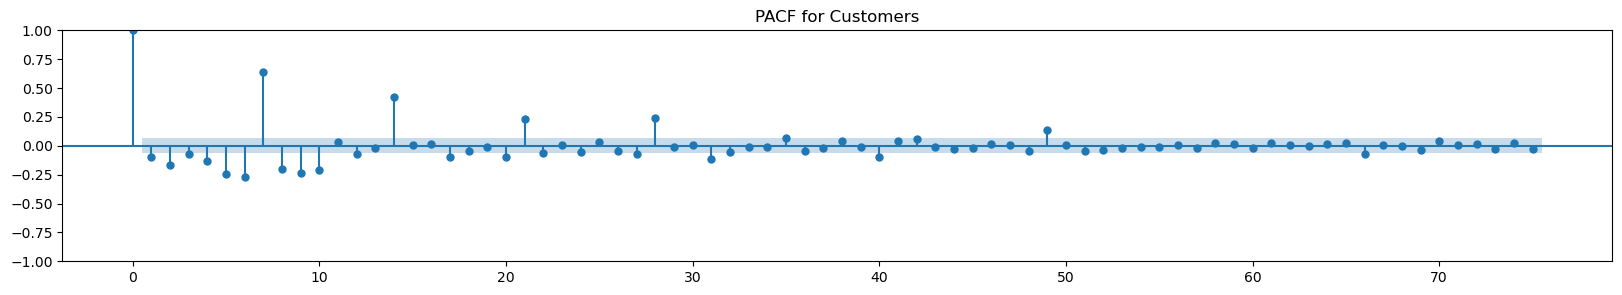

In [139]:
# Plotting ACF and PACF for Customers
plot_acf_pacf(train_df_all['Customers'],'Customers')

- For ACF, we set q=0 as co-realation never comes dowm. For PACF, we set p=7, since it is the highest lag since inception.

# Splitting Train/Test

- We need to predict sales for the next 6 weeks i.e 42 days. So, we keep 42 days for test and remaining for training.

In [143]:
train_df_all.shape

(942, 11)

- We will use first 900 rows for train and last 42 for test

In [145]:
# Creating train and test splits
train_len=900
train_df_all_train=train_df_all.iloc[:train_len,:]
train_df_all_test=train_df_all.iloc[train_len:,:]

- Standardising numerical values in test-train datasets using minmax

In [147]:
from sklearn.preprocessing import MinMaxScaler
# Fit transform on train data
scaler = MinMaxScaler()
train_df_all_train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train_df_all_train[['Sales','Customers','Promo','SchoolHoliday']])
train_df_all_train.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,
2013-01-01,0.000000,0.000000,0.0,0.999103,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.441350,0.543373,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.402577,0.494654,0.0,0.932735,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,0.421328,0.508727,0.0,0.932735,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,0.377057,0.445579,0.0,0.100448,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [148]:
# Transform on test data
train_df_all_test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(train_df_all_test[['Sales','Customers','Promo','SchoolHoliday']])
train_df_all_test.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,
2015-06-20,0.405336,0.453472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-06-21,0.009824,0.015096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-06-22,0.415762,0.489576,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-06-23,0.399006,0.475851,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-06-24,0.396755,0.474848,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Vector AutoRegressive Model(VAR)

In [150]:
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_1','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.15      -12.04   5.306e-06      -12.11
1       -12.26      -12.13   4.720e-06      -12.21
2       -12.26      -12.11   4.733e-06      -12.20
3       -12.30      -12.13   4.554e-06      -12.23
4       -12.30      -12.11   4.535e-06      -12.23
5       -12.30      -12.09   4.530e-06      -12.22
6       -12.31      -12.08   4.489e-06      -12.22
7       -12.32      -12.06   4.468e-06      -12.22
8       -12.47      -12.19   3.838e-06      -12.36
9       -12.50     -12.20*   3.724e-06      -12.39
10      -12.52      -12.19   3.664e-06      -12.39
11      -12.54      -12.19   3.597e-06      -12.40
12      -12.53      -12.16   3.621e-06      -12.39
13      -12.54      -12.15   3.590e-06      -12.39
14      -12.58      -12.17   3.436e-06     -12.42*
15     -12.59*      -12.16  3.410e-06*      -12.42
-------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


- AIC is the lowest at lag 11

In [152]:
# Fitting the model with lag 11
var_model_final = var_model.fit(11)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Feb, 2025
Time:                     10:44:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.1953
Nobs:                     889.000    HQIC:                  -12.4083
Log likelihood:           3115.22    FPE:                3.58025e-06
AIC:                     -12.5401    Det(Omega_mle):     3.33578e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.227101              NAN              NAN             NAN
Promo                 0.169451         0.016253           10.426           0.000
SchoolHoliday        -0.033177         0.012694           -2

- Perform Johassen test with p=10

- Creating function for johassen test for checking cointegration

In [155]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

def cointegration_test(df, lag): 
    alpha=0.05
    out = coint_johansen(df,-1,lag)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [156]:
train_df_all['Sales']=train_df_all['Sales'].apply(lambda x:round(x))
train_df_all['Customers']=train_df_all['Customers'].apply(lambda x:round(x))

In [157]:
cointegration_test(train_df_all[['Sales','Customers']],10)
rank_result=select_coint_rank(train_df_all[['Sales','Customers']],-1,10)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  55.77     > 12.3212   =>   True
Customers ::  0.32      > 4.1296    =>   False


- We have the rank of Johassen test as 2 which means that the time series are stationary but do not seem to be co-integratied

In [159]:
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_all_train[['Sales','Customers']].values[-lag_order:]
forecast_input

11


array([[0.43595062, 0.50832754],
       [0.41397174, 0.4892133 ],
       [0.41579704, 0.49799996],
       [0.41923316, 0.49742961],
       [0.41303913, 0.45743139],
       [0.0110916 , 0.01718541],
       [0.73892895, 0.69369782],
       [0.61440719, 0.61305964],
       [0.54882338, 0.56709914],
       [0.5213138 , 0.5473912 ],
       [0.53850368, 0.5678536 ]])

# Forecasting using VAR

In [161]:
exog_test = train_df_all_test[['Promo','SchoolHoliday','DayOfWeek_1','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_all_test.index, columns=['Sales','Customers'])
var_forecast

,Sales,Customers
Date,,
2015-06-20,0.441004,0.500055
2015-06-21,0.015879,0.013267
2015-06-22,0.427535,0.508562
2015-06-23,0.414973,0.506646
2015-06-24,0.377980,0.462299
2015-06-25,0.343401,0.426233
2015-06-26,0.434158,0.515352
2015-06-27,0.419477,0.473930
2015-06-28,0.021367,0.018221


In [162]:
# Adding forecasted values
train_df_all_test['VarForecastedSales']=var_forecast.Sales
train_df_all_test['VarForecastedCustomers']=var_forecast.Customers

- Creating a function for results visualization

In [164]:
def forecasted_timeseries_visualization(series,forecasted_series,c,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label='Actual')
    forecasted_series.plot(label='Forecasted')
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.legend(loc='best')
    plt.title('{} model For {}'.format(model,c))
    plt.show()

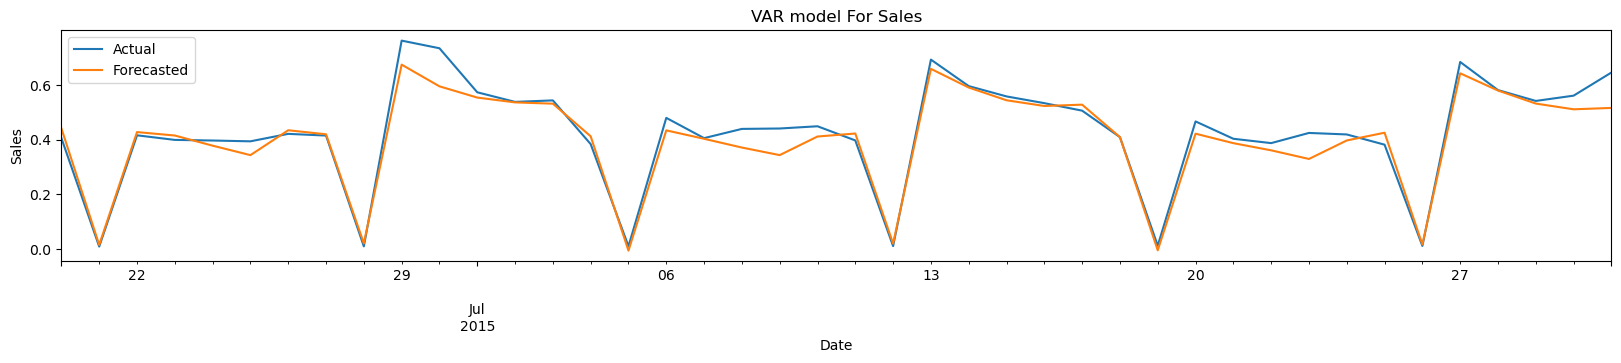

In [165]:
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['VarForecastedSales'],'Sales','VAR')

### Storing results in a dataframe

In [167]:
from sklearn.metrics import mean_squared_error
summary_df=pd.DataFrame(columns=['Store','Model','RMSE_SALES','MAPE_SALES','RMSE_CUSTOMERS','MAPE_CUSTOMERS'])

def summary(s,fs,c,fc,store,model):
    rmse_sales = np.sqrt(mean_squared_error(s, fs)).round(2)
    mape_sales = np.round(np.mean(np.abs(s-fs)/s)*100,2)
    rmse_customers = np.sqrt(mean_squared_error(c, fc)).round(2)
    mape_customers = np.round(np.mean(np.abs(c-fc)/c)*100,2)
    temp=pd.DataFrame({'Store':[store],'Model':[model], 'RMSE_SALES': [rmse_sales],'MAPE_SALES': [mape_sales] , 
                            'RMSE_CUSTOMERS': [rmse_customers],'MAPE_CUSTOMERS': [mape_customers]})
    return temp

In [168]:
d=summary(train_df_all_test['Sales'], train_df_all_test['VarForecastedSales'],
       train_df_all_test['Customers'], train_df_all_test['VarForecastedCustomers'],'All','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head()


,Store,Model,RMSE_SALES,MAPE_SALES,RMSE_CUSTOMERS,MAPE_CUSTOMERS
0,All,VAR,0.05,19.37,0.03,9.1


## Forecasting using VARMAX

- We had used q=0 and p=7 for VAR

In [171]:
# modelling
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_1','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                3030.775
                              + intercept   AIC                          -5959.550
Date:                    Tue, 18 Feb 2025   BIC                          -5714.628
Time:                            10:48:04   HQIC                         -5865.988
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            3.13, 34.42   Jarque-Bera (JB):     5601.15, 1847.55
Prob(Q):                        0.08, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.62, 1.51   Skew:                     -1.76, -1.49
P

In [172]:
#forecasting on test data

exog_test = train_df_all_test[['Promo','SchoolHoliday','DayOfWeek_1','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_all_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_all_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

,Sales,Customers
Date,,
2015-06-20,0.442030,0.501240
2015-06-21,0.009875,0.009029
2015-06-22,0.458058,0.524346
2015-06-23,0.403281,0.496428
2015-06-24,0.363991,0.460648


In [173]:
# Adding forecasted values
train_df_all_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_all_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

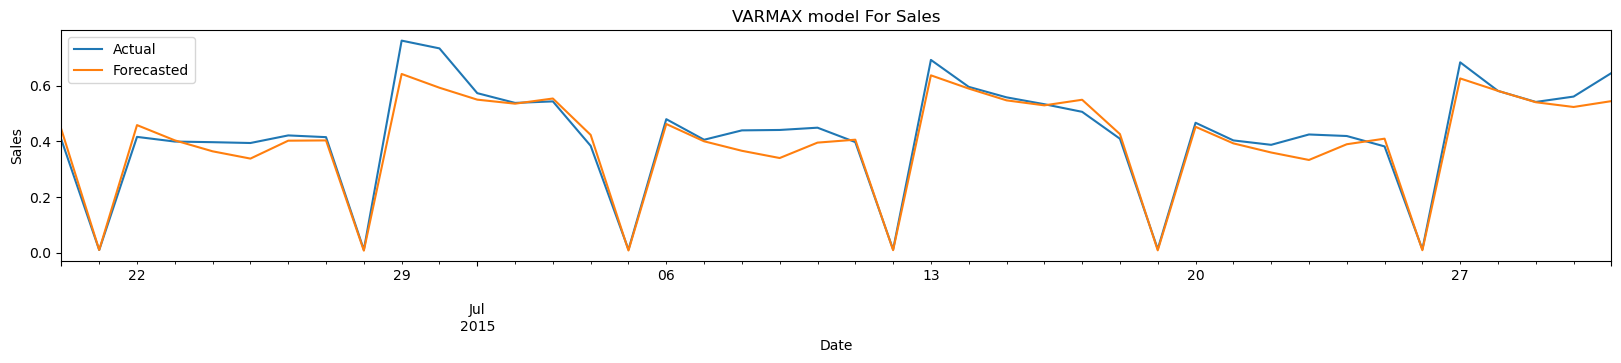

In [174]:
# Plotting time series
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [175]:
# Printing results
d=summary(train_df_all_test['Sales'], train_df_all_test['VarmaxForecastedSales'],
       train_df_all_test['Customers'], train_df_all_test['VarmaxForecastedCustomers'],'All','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head()

,Store,Model,RMSE_SALES,MAPE_SALES,RMSE_CUSTOMERS,MAPE_CUSTOMERS
0,All,VAR,0.05,19.37,0.03,9.10
0,All,VARMAX,0.05,9.53,0.03,8.39
